In [ ]:
!nvidia-smi

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow: {tf.__version__}")
print(f"GPUs: {gpus}")

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU ENABLED!")
else:
    print("❌ NO GPU! Go to Runtime → Change runtime type → GPU")


Thu Feb  5 13:57:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("✅ Libraries imported!")


✅ Libraries imported!


In [4]:
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted!")


Mounted at /content/drive
✅ Drive mounted!


In [5]:
import os

DATASET_PATH = '/content/drive/MyDrive/CaptoneProject/camera'
ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'

if os.path.exists(ZIP_PATH):
    print(f"✅ ZIP found at {ZIP_PATH}")
else:
    print("⚠️ ZIP not found! Please run the specific zip creation cell if needed.")


✅ ZIP found at /content/drive/MyDrive/CaptoneProject/camera.zip


In [6]:
import os
import shutil

ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'
LOCAL_PATH = '/content/dataset'

if not os.path.exists(LOCAL_PATH):
    if os.path.exists(ZIP_PATH):
        print("📦 Unzipping... (this might take a moment)")
        !unzip -q -o "{ZIP_PATH}" -d /content/

        # Handle directory structure
        if os.path.exists('/content/camera'):
            !mv /content/camera "{LOCAL_PATH}"
        elif os.path.exists('/content/train') and os.path.exists('/content/test'):
            os.makedirs(LOCAL_PATH, exist_ok=True)
            !mv /content/train "{LOCAL_PATH}/train"
            !mv /content/test "{LOCAL_PATH}/test"
        print("✅ Dataset ready at /content/dataset")
    else:
        print("❌ ZIP file not found in Drive!")
else:
    print("✅ Dataset already exists locally!")

TRAIN_DIR = os.path.join(LOCAL_PATH, 'train')
TEST_DIR = os.path.join(LOCAL_PATH, 'test')


📦 Unzipping... (this might take a moment)
✅ Dataset ready at /content/dataset


In [7]:
# ========================================
# CONFIG: METHOD 2 - SE ATTENTION CNN
# ========================================
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0005
NUM_CLASSES = 7
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

CHECKPOINT_DIR = '/content/drive/MyDrive/CaptoneProject/checkpoints/method2_se'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
MODEL_CHECKPOINT_PATH = f'{CHECKPOINT_DIR}/checkpoint.keras'
BEST_MODEL_PATH = f'{CHECKPOINT_DIR}/best_model.keras'
HISTORY_PATH = f'{CHECKPOINT_DIR}/history.pkl'


In [8]:
# Standard Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=15, width_shift_range=0.15, height_shift_range=0.15,
    shear_range=0.15, zoom_range=0.15, horizontal_flip=True, fill_mode='nearest', validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(48,48), color_mode='grayscale', batch_size=BATCH_SIZE, class_mode='categorical', subset='training', seed=SEED)
validation_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(48,48), color_mode='grayscale', batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', seed=SEED)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(48,48), color_mode='grayscale', batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
train_labels = train_generator.classes
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights_array))

print("📊 Class Weights calculated!")


📊 Class Weights calculated!


In [10]:
def squeeze_excitation_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

def build_se_cnn(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = squeeze_excitation_block(x, ratio=8)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = squeeze_excitation_block(x, ratio=8)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = squeeze_excitation_block(x, ratio=16)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = squeeze_excitation_block(x, ratio=16)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Classifier using GAP
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = build_se_cnn()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        576 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 48, 48,    │          0 │ activation_1[0][… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │    147,584 │ activation_2[0][

 Total params: 5,137,871 (19.60 MB)

 Trainable params: 5,132,495 (19.58 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [11]:
class SaveHistoryCallback(keras.callbacks.Callback):
    def __init__(self, history_path, checkpoint_path):
        super().__init__()
        self.history_path = history_path
        self.checkpoint_path = checkpoint_path
        self.history_data = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'lr': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history_data['accuracy'].append(logs.get('accuracy'))
        self.history_data['val_accuracy'].append(logs.get('val_accuracy'))
        self.history_data['loss'].append(logs.get('loss'))
        self.history_data['val_loss'].append(logs.get('val_loss'))
        self.history_data['lr'].append(float(self.model.optimizer.learning_rate.numpy()))

        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history_data, f)
        # Save checkpoint periodically or on best is handled by ModelCheckpoint,
        # but we can save here too if needed.
        # self.model.save(self.checkpoint_path)

callbacks = [
    ModelCheckpoint(filepath=BEST_MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    SaveHistoryCallback(HISTORY_PATH, MODEL_CHECKPOINT_PATH)
]
print("✅ Callbacks configured!")


✅ Callbacks configured!


In [12]:
print("🚀 Starting Training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)
print("✅ Training Completed!")


🚀 Starting Training...
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1592 - loss: 3.1280
Epoch 1: val_accuracy improved from -inf to 0.12280, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/method2_se/best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.1591 - loss: 3.1276 - val_accuracy: 0.1228 - val_loss: 2.6702 - learning_rate: 5.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1765 - loss: 2.7126
Epoch 2: val_accuracy improved from 0.12280 to 0.18185, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/method2_se/best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.1765 - loss: 2.7125 - val_accuracy: 0.1818 - val_loss: 2.5389 - learning_rate: 5.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1781 - loss: 2.5099
Epoch 3: val_accuracy improved from 0.18185 to 0.22749, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/m

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6061 - loss: 1.2587

🎯 TEST ACCURACY: 64.22%
   TEST LOSS: 1.1997
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
              precision    recall  f1-score   support

       angry     0.5453    0.6033    0.5728       958
     disgust     0.3989    0.6396    0.4913       111
        fear     0.5748    0.3076    0.4008      1024
       happy     0.8710    0.8489    0.8598      1774
     neutral     0.5252    0.7445    0.6159      1233
         sad     0.5523    0.4362    0.4875      1247
    surprise     0.7290    0.8159    0.7700       831

    accuracy                         0.6422      7178
   macro avg     0.5995    0.6280    0.5997      7178
weighted avg     0.6468    0.6422    0.6334      7178



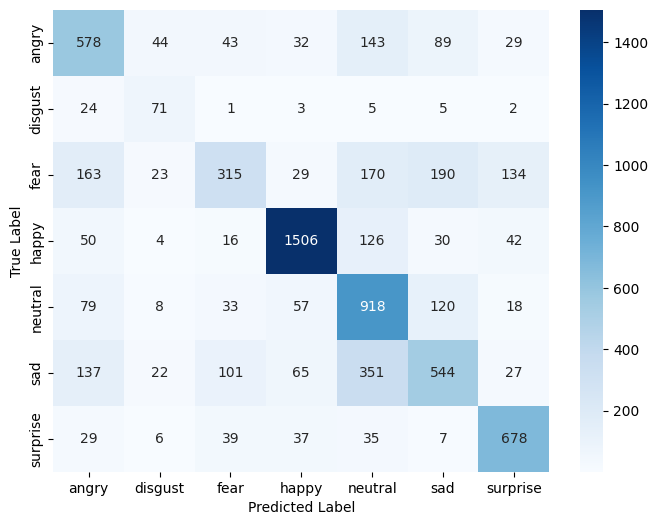

In [13]:
# Load best model
best_model = keras.models.load_model(BEST_MODEL_PATH)

test_generator.reset()
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\n🎯 TEST ACCURACY: {test_acc*100:.2f}%")
print(f"   TEST LOSS: {test_loss:.4f}")

# Predictions
predictions = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
